In [546]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

In [547]:
base_dir="/root/vllm/benchmarks/result"

In [548]:
date = "20240627"
counter = 36
dir_name = os.path.join(base_dir, date, str(counter))

In [549]:
dfs = {}
for file in os.listdir(dir_name):
    if file.endswith(".json"):

        with open(os.path.join(dir_name, file), "r") as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        df.drop(columns=['date','backend','tokenizer_id','best_of','use_beam_search'], inplace=True)
        df.replace({"fcfs": "FCFS", "infer":"Infer","full":"Full","half":"Half"},inplace=True)
        dfs[file]= df
        

(0.0, 2.1)

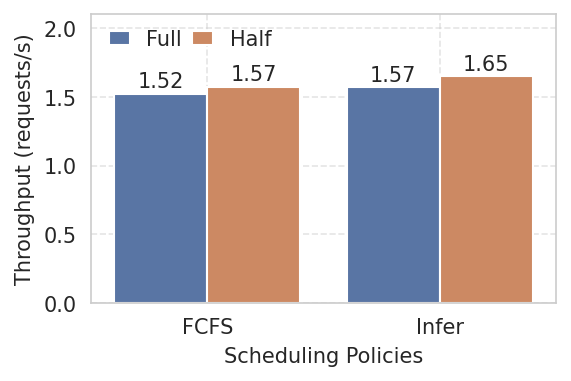

In [550]:
# plot the average throughput with different scheduling policies and swap policies
result = {"scheduling_policies": [], "swap_policies": [], "throughput": []}
for df_name in dfs:
    tmp_df = dfs[df_name]
    result["scheduling_policies"].append(tmp_df["scheduler_policy"].iloc[0])
    result["swap_policies"].append(tmp_df["swap_policy"].iloc[0])
    result["throughput"].append(tmp_df["request_throughput"].mean())
result_df = pd.DataFrame(result)
result_df = result_df.groupby(["scheduling_policies", "swap_policies"]).mean().reset_index()
sns.set_style(style="whitegrid")
sns.set_palette("deep")
plt.figure(figsize=(4, 2.5), dpi=150)
ax = sns.barplot(
    x="scheduling_policies", y="throughput", hue="swap_policies", data=result_df
)
# add the number of each bar in ax
for p in ax.patches:
    if p.get_height() == 0:
        continue
    ax.annotate(
        str(round(p.get_height(), 2)),
        (p.get_x() + p.get_width() / 2.0, p.get_height()*1),
        ha="center",
        va="center",
        xytext=(0, 6),
        textcoords="offset points",
    )

plt.xlabel("Scheduling Policies")
plt.ylabel("Throughput (requests/s)")
plt.legend(loc=(0.02,0.85), frameon=False, ncol=2, handlelength=1.0, columnspacing=0.5)
plt.grid(linestyle="--", alpha=0.5)
plt.ylim(0, 2.1)

In [551]:
columns = dfs[next(iter(dfs))].columns.tolist()

In [552]:
dfs[next(iter(dfs))].columns

Index(['model_id', 'num_prompts', 'swap_space', 'preemption_mode',
       'scheduler_policy', 'gpu_memory_utilization', 'max_num_seqs',
       'max_tokens', 'swap_policy', 'iter_theshold', 'swap_out_partial_rate',
       'request_rate', 'duration', 'completed', 'total_input_tokens',
       'total_output_tokens', 'request_throughput', 'input_throughput',
       'output_throughput', 'mean_ttft_ms', 'median_ttft_ms', 'p99_ttft_ms',
       'mean_tpot_ms', 'median_tpot_ms', 'p99_tpot_ms', 'mean_itl_ms',
       'median_itl_ms', 'p99_itl_ms', 'mean_lat_ms', 'median_lat_ms',
       'p99_lat_ms', 'input_lens', 'output_lens', 'ttfts', 'itls',
       'latencies'],
      dtype='object')

In [553]:
# Initialize result dictionary
result = {"scheduler_policy": [], "swap_policy": []}
selected_columns = ['mean_ttft_ms', 'median_ttft_ms', 'p99_ttft_ms', 'mean_tpot_ms',
                    'median_tpot_ms', 'p99_tpot_ms', 'mean_itl_ms', 'median_itl_ms',
                    'p99_itl_ms',"mean_lat_ms", "median_lat_ms", "p99_lat_ms"]

for column in selected_columns:
    result[column] = []

# Populate result dictionary with data
for df_name in dfs:
    df = dfs[df_name]
    for column in result.keys():
        if column in df.columns:
            if isinstance(df[column][0], float):
                result[column].append(df[column].mean())
            else:
                result[column].append(df[column][0])

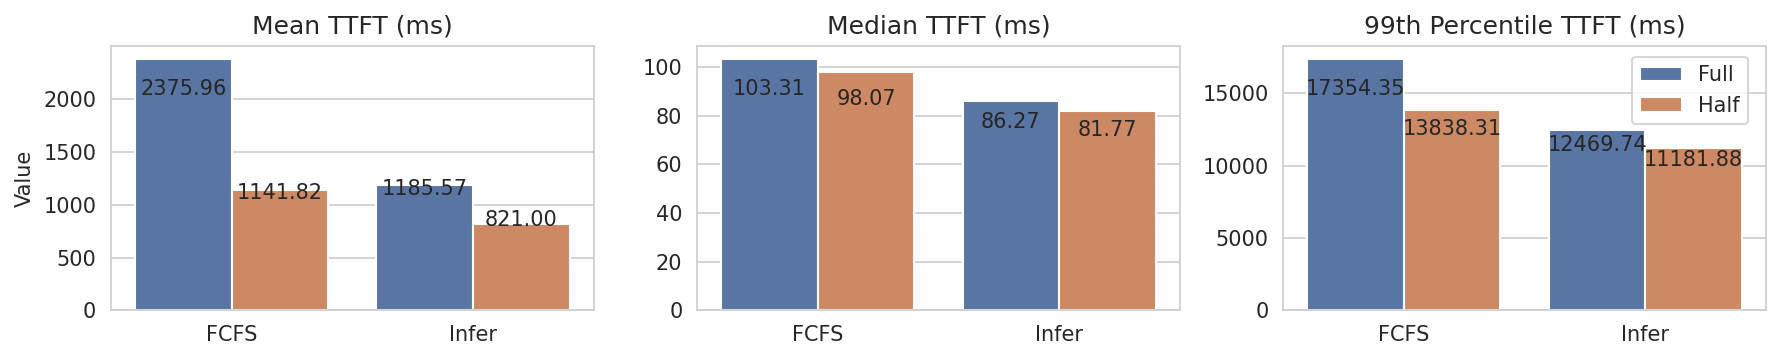

In [554]:

# Convert result dictionary to DataFrame
result_df = pd.DataFrame(result)
result_df = result_df.groupby(['scheduler_policy','swap_policy']).mean().reset_index()
# Select ttft-related metrics
ttft_columns = ['mean_ttft_ms', 'median_ttft_ms', 'p99_ttft_ms']
lat_df = result_df[['scheduler_policy', 'swap_policy'] + ttft_columns]


# Create the DataFrame to long format
tpot_long_df = lat_df.melt(id_vars=['scheduler_policy', 'swap_policy'], 
                            value_vars=ttft_columns, 
                            var_name='Metric', 
                            value_name='Value')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=150, nrows=1, ncols=3)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=tpot_long_df[tpot_long_df['Metric'] =='mean_ttft_ms'], ax=ax[0],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=tpot_long_df[tpot_long_df['Metric'] =='median_ttft_ms'], ax=ax[1],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=tpot_long_df[tpot_long_df['Metric'] == 'p99_ttft_ms'], ax=ax[2])

for i in range(3):
    for p in ax[i].patches:
        if p.get_height() == 0:
            continue
        ax[i].annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()*.8), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax[0].set_title('Mean TTFT (ms)')
ax[1].set_title('Median TTFT (ms)')
ax[2].set_title('99th Percentile TTFT (ms)')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('Value')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.legend(bbox_to_anchor=(.7, 1), loc='upper left')
plt.tight_layout()
plt.show()


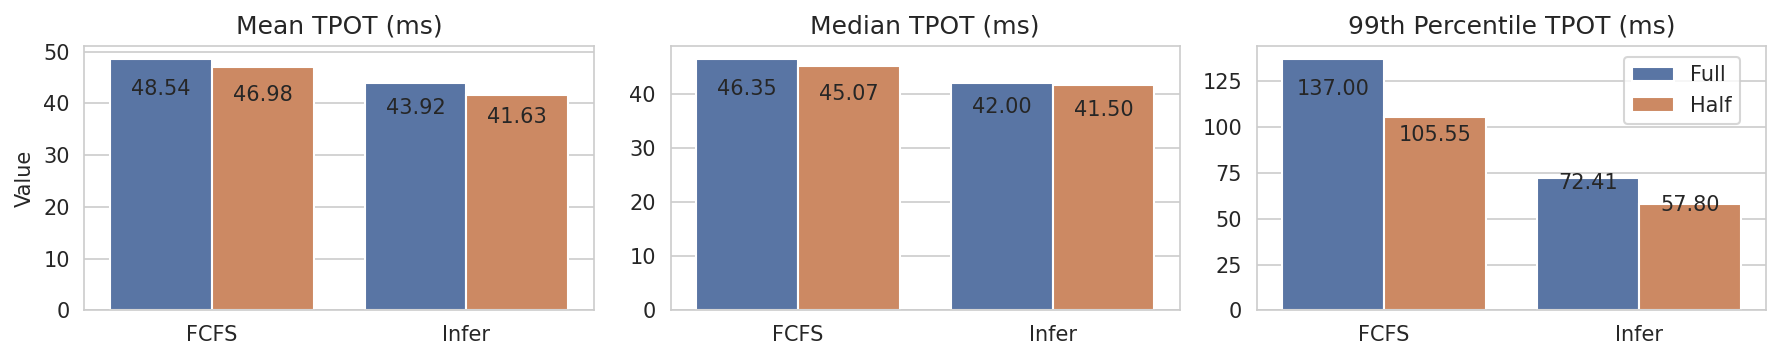

In [555]:
# plot TPOT

# Convert result dictionary to DataFrame
result_df = pd.DataFrame(result)
result_df = result_df.groupby(['scheduler_policy','swap_policy']).mean().reset_index()
# Select ttft-related metrics
tpot_columns = ['mean_tpot_ms', 'median_tpot_ms', 'p99_tpot_ms']
tpot_df = result_df[['scheduler_policy', 'swap_policy'] + tpot_columns]


# Create the DataFrame to long format
tpot_long_df = tpot_df.melt(id_vars=['scheduler_policy', 'swap_policy'], 
                            value_vars=tpot_columns, 
                            var_name='Metric', 
                            value_name='Value')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=150, nrows=1, ncols=3)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=tpot_long_df[tpot_long_df['Metric'] =='mean_tpot_ms'], ax=ax[0],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=tpot_long_df[tpot_long_df['Metric'] =='median_tpot_ms'], ax=ax[1],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=tpot_long_df[tpot_long_df['Metric'] == 'p99_tpot_ms'], ax=ax[2])

for i in range(3):
    for p in ax[i].patches:
        if p.get_height() == 0:
            continue
        ax[i].annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()*.8), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax[0].set_title('Mean TPOT (ms)')
ax[1].set_title('Median TPOT (ms)')
ax[2].set_title('99th Percentile TPOT (ms)')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('Value')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.legend(bbox_to_anchor=(.7, 1), loc='upper left')
plt.tight_layout()
plt.show()



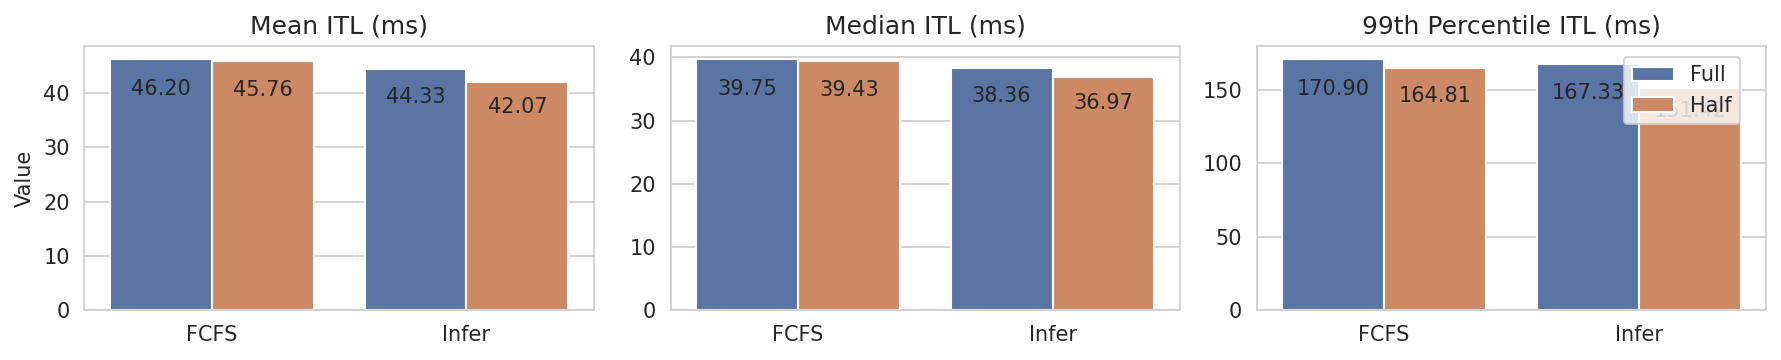

In [556]:
# plot itl

# Convert result dictionary to DataFrame
result_df = pd.DataFrame(result)
# Select itl-related metrics
itl_columns = ['mean_itl_ms', 'median_itl_ms', 'p99_itl_ms']
itl_df = result_df[['scheduler_policy', 'swap_policy'] + itl_columns]
itl_df = itl_df.groupby(['scheduler_policy','swap_policy']).mean().reset_index()

# Create the DataFrame to long format
itl_long_df = itl_df.melt(id_vars=['scheduler_policy', 'swap_policy'], 
                            value_vars=itl_columns, 
                            var_name='Metric', 
                            value_name='Value')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=150, nrows=1, ncols=3)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=itl_long_df[itl_long_df['Metric'] =='mean_itl_ms'], ax=ax[0],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=itl_long_df[itl_long_df['Metric'] =='median_itl_ms'], ax=ax[1],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=itl_long_df[itl_long_df['Metric'] == 'p99_itl_ms'], ax=ax[2])

for i in range(3):
    for p in ax[i].patches:
        if p.get_height() == 0:
            continue
        ax[i].annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()*.8), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax[0].set_title('Mean ITL (ms)')
ax[1].set_title('Median ITL (ms)')
ax[2].set_title('99th Percentile ITL (ms)')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('Value')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.legend(bbox_to_anchor=(.7, 1), loc='upper left')
plt.tight_layout()
plt.show()



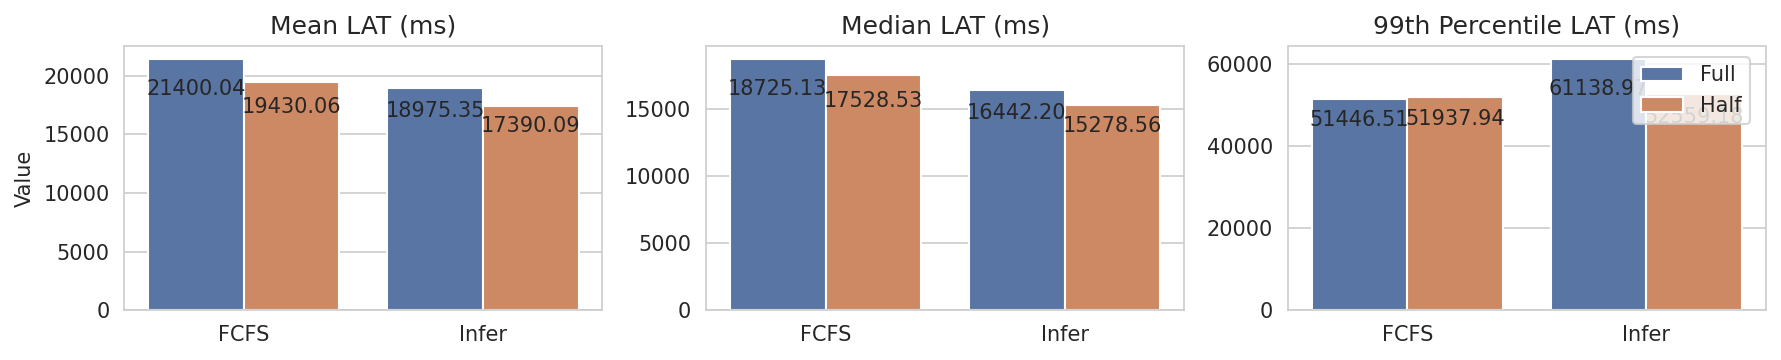

In [557]:
# plot lat

# Convert result dictionary to DataFrame
result_df = pd.DataFrame(result)

# Select ttft-related metrics
lat_columns = ['mean_lat_ms', 'median_lat_ms', 'p99_lat_ms']
lat_df = result_df[['scheduler_policy', 'swap_policy'] + lat_columns]
lat_df=lat_df.groupby(['scheduler_policy','swap_policy']).mean().reset_index()

# Create the DataFrame to long format
lat_long_df = lat_df.melt(id_vars=['scheduler_policy', 'swap_policy'], 
                            value_vars=lat_columns, 
                            var_name='Metric', 
                            value_name='Value')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=150, nrows=1, ncols=3)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=lat_long_df[lat_long_df['Metric'] =='mean_lat_ms'], ax=ax[0],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=lat_long_df[lat_long_df['Metric'] =='median_lat_ms'], ax=ax[1],legend=False)
sns.barplot(x='scheduler_policy', y='Value', hue='swap_policy', data=lat_long_df[lat_long_df['Metric'] == 'p99_lat_ms'], ax=ax[2])

for i in range(3):
    for p in ax[i].patches:
        if p.get_height() == 0:
            continue
        ax[i].annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()*.8), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax[0].set_title('Mean LAT (ms)')
ax[1].set_title('Median LAT (ms)')
ax[2].set_title('99th Percentile LAT (ms)')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('Value')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.legend(bbox_to_anchor=(.7, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [558]:
# Initialize result dictionary
result = {"scheduler_policy": [], "swap_policy": []}
selected_columns = ["ttfts","itls","latencies"]

for column in selected_columns:
    result[column] = []

# Populate result dictionary with data
for df_name in dfs:
    df = dfs[df_name]
    for column in result.keys():
        if column in df.columns:
            if isinstance(df[column][0], float):
                result[column].append(df[column])
            else:
                result[column].append(df[column][0])

In [559]:
def explode_row(row):
    ttft = row['ttfts']
    itl = row['itls']
    latencies=row['latencies']
    total_length = len(ttft)+len(itl)+len(latencies)
    
    # 填充列表以确保它们的长度一致
    # 创建一个新的数据框
    new_df = pd.DataFrame({
        'scheduler_policy': [row['scheduler_policy']] * total_length,
        'swap_policy': [row['swap_policy']] * total_length,
        'type': ["ttft"]*len(ttft) + ["itl"]*len(itl) + ["latency"]*len(latencies),
        "value": ttft + itl + latencies
    })
    
    return new_df

In [560]:
result_df = pd.DataFrame(result)
result_df['ttfts'] = result_df['ttfts'].apply(lambda x:x.tolist())
result_df['latencies']=result_df['latencies'].apply(lambda x:x.tolist())
long_df=result_df.apply(lambda x: explode_row(x), axis=1, result_type='reduce').reset_index(drop=True)
long_df=pd.concat([long_df[i] for i in range(len(long_df))])
long_df['hue']=long_df['swap_policy']+" "+long_df["scheduler_policy"]

In [561]:
long_df[long_df['type']=='itl']

,scheduler_policy,swap_policy,type,value,hue
300,Infer,Half,itl,0.019564,Half Infer
301,Infer,Half,itl,0.019525,Half Infer
302,Infer,Half,itl,0.019491,Half Infer
303,Infer,Half,itl,0.019521,Half Infer
304,Infer,Half,itl,0.019535,Half Infer
...,...,...,...,...,...
630,FCFS,Full,itl,0.024117,Full FCFS
631,FCFS,Full,itl,0.024529,Full FCFS
632,FCFS,Full,itl,0.023706,Full FCFS
633,FCFS,Full,itl,0.024238,Full FCFS


(0.95, 1.0)

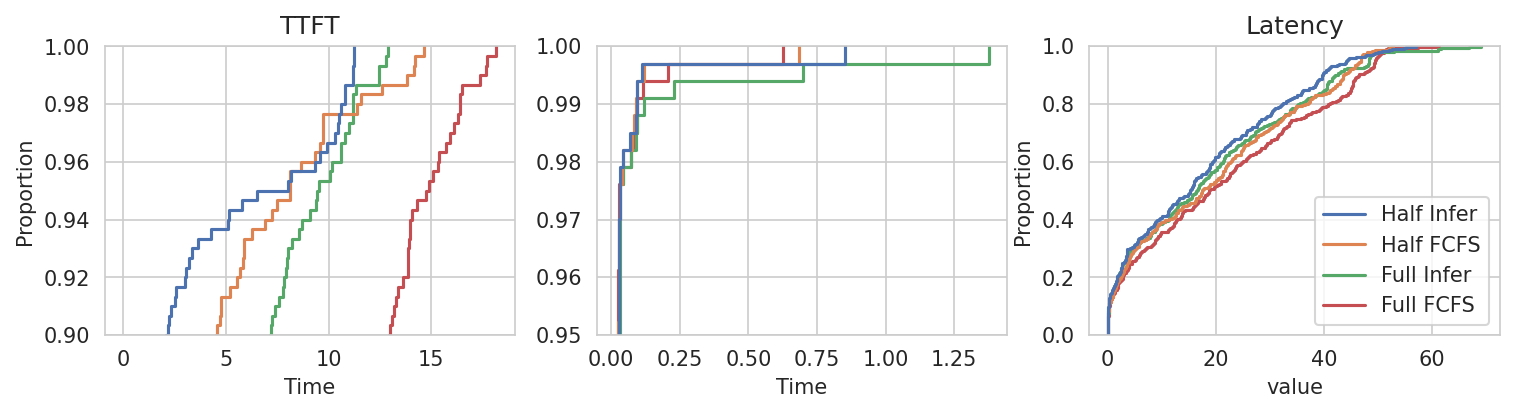

In [570]:
# plot ecdf figures for different scheduler policy and swap policy
colors = sns.color_palette("deep",n_colors=4)
count=0
fig, ax = plt.subplots(figsize=(12,2.5),dpi=150,ncols=3,nrows=1)
sns.ecdfplot(data=long_df[long_df['type']=='ttft'],x='value',hue='hue',palette=colors,ax=ax[0],legend=False)
sns.ecdfplot(data=long_df[long_df['type']=='itl'],x='value',hue='hue',palette=colors,ax=ax[1],legend=False)
sns.ecdfplot(data=long_df[long_df['type']=='latency'],x='value',hue='hue',palette=colors,ax=ax[2])
ax[0].set_title('TTFT')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('')
# ax[1].set_yscale('log')
ax[2].set_title('Latency')
ax[2].get_legend().set_title('')
ax[0].set_ylim(0.9,1)
ax[1].set_ylim(0.95,1)